# Foundations of Data Mining: Assignment 1

Please complete all assignments in this notebook. You should submit this notebook, as well as a PDF version (See File > Download as).

##### 2IMW30 - Foundations of Data Mining 
##### Assignment 1
##### Ruud Andriessen - 0770663
##### Wesley Brants - 0817020

In [1]:
%matplotlib inline
from preamble import *
plt.rcParams['savefig.dpi'] = 100
# InteractiveShell.ast_node_interactivity = "all"

## Handwritten digit recognition (5 points, 1+2+2)
The [MNIST dataset](https://www.openml.org/d/554) contains 70,000 images of handwritten digits (0-9) represented by 28 by 28 pixel values. We can easily download it from OpenML and visualize one of the examples:

In [2]:
# This is a temporary read-only OpenML key. Replace with your own key later. 
oml.config.apikey = '11e82c8d91c5abece86f424369c71590'

In [3]:
# Load MNIST data
mnist_data = oml.datasets.get_dataset(554) # Download MNIST data
X, y = mnist_data.get_data(target=mnist_data.default_target_attribute); # Get the predictors X and the labels y

- Evaluate a k-Nearest Neighbor classifier with its default settings.
    - Use the first 60,000 examples as the training set and the last 10,000 as the test set
    - What is the predictive accuracy?
    - Find a few misclassifications, and plot them together with the true labels (as above). Are these images really hard to classify?
- Optimize the value for the number of neighbors $k$ (keep $k$ < 50) on a stratified subsample (e.g. 10%) of the data
    - Use 10-fold crossvalidation and plot $k$ against the misclassification rate. Which value of $k$ should you pick?
    - Do the same but with 100 bootstrapping repeats. Are the results different? Explain.
- Compare kNN against the linear classification models that we have covered in the course (logistic regression and linear SVMs).
    - First use the default hyperparameter settings.
    - Next, optimize for the degree of regularization ($C$) and choice of penalty (L1/L2). Again, plot the accuracy while increasing the degree of regularization for different penalties. Interpret the results. 
    - Report is the optimal performance. Can you get better results than kNN?
    
Report all results clearly and interpret the results.  
Note: while prototyping/bugfixing, you can speed up experiments by taking a smaller sample of the data, but report your results as indicated above.

In [4]:
# Import all libraries
from sklearn import neighbors, linear_model
import math


### Evaluating a k-Nearest Neighbor classifier with its default settings.
We first evaluate the k-Nearest Neighbor classifier with the default settings on the data. We calculate the predictive accuracy and plot several misclassifications of the classifier. 

Running on 70000 elements with 60000 train size
Predictive accuracy: 0.968800


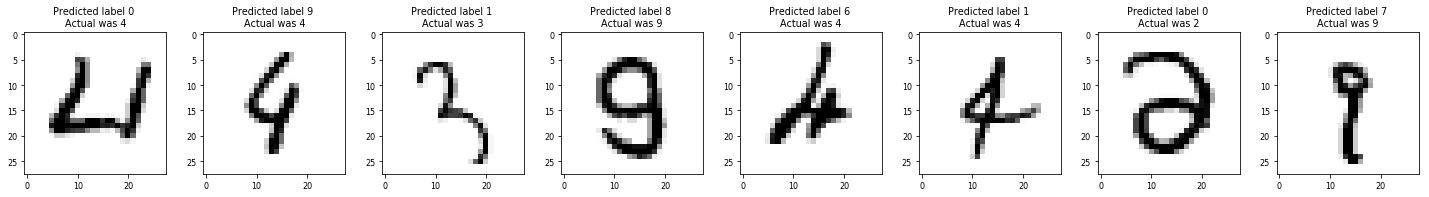

In [35]:
# -- Settings --
samples = 8                                 # The number of invalid samples to plot
dataSize = 70000                            # The size of our data
split = 60000/dataSize                      # Split percentage
percentage = 1                           # A multiplier which controls the percentage of data we use, set to 1 to run with all data
numElements = int(percentage*dataSize)      # The number of elements we actually use in the run
trainSize = int(percentage*dataSize*split)  # The size of the training dataset

# Print the amount of elements we run on
print("Running on %i elements with %i train size" % (numElements, trainSize))

# Split 60.000/10.000 for both the predictors and labels
X_train, X_test = np.split(X[:numElements],[trainSize])
y_train, y_test = np.split(y[:numElements],[trainSize])

# Initialize knn with default values
knn = neighbors.KNeighborsClassifier()

# Fit knn to training data
knn.fit(X_train, y_train)

# Use knn to predict test data
y_pred = knn.predict(X_test)

# Print predictive accuracy
print('Predictive accuracy: %f' % knn.score(X_test, y_test))

# Print {samples} amount of figures with wrong results
fig, axes = plt.subplots(1, samples, figsize=(20, 3))
plt.tight_layout() 
sample = 0
i = 0
while sample < samples or i > len(y_pred):
    if (y_pred[i] != y_test[i]):
        axes[sample].imshow(X_test[i].reshape(28, 28), cmap=plt.cm.gray_r)
        axes[sample].set_title("Predicted label {} \nActual was {}".format(y_pred[i], y_test[i]))
        sample += 1
    i+=1
    
plt.show()

When using the first 60000 examples as a training set and the last 10000 as test set, we get an accuracy of 0.968800.

When looking at the invalid classifications, some are unexpected. For example: the fourth sample (the 9) is clearly an 9 and does not seem significantly hard.

However, most samples are indeed very hard. For example, the 1st sample (the 4) does not look like a 4 at all. Similarly, the 7th sample (the 2) is extremely sloppy, as to the point where we feel it does not represent a number at all. Some can be understood by the human mind, but it is understandable that an algorithm makes these kind of mistakes

Therefore, we conclude the classifier can definitly be improved, however, we also note that some samples are very difficult, even for a human to predict the correct result.

### Optimizing the kNN classifier
We started to look for optimization methods for the kNN classifier, using 10-fold crossvalidation we attempted to find the optimal k for our model by plotting the train and test accuracy of different values of k. 

Additionally, we did the same but this time with 100 bootstrapping repeats. This is done as follows:

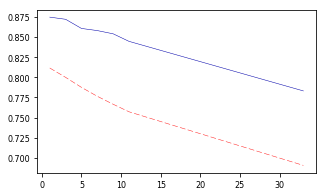

In [54]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit

# Build a list of the training and test scores for increasing amount of neighbors
test_accuracy = []
accuracy_bootstrap = []

# Take a stratified subsample
x_data, _, y_data, _ = train_test_split(X, y, train_size=0.1, stratify=y)

# Create k-fold and bootstrap
kf = KFold(n_splits=10, shuffle=True, random_state=0)
bootstrap = ShuffleSplit(test_size=.66, train_size=.34, n_splits=100)

# Set range of k values to be tested
k = [1, 3, 5, 7, 9, 11, 33]

# uses kf-old testing to find training and test accuracy for different amount of neighbors
for n_neighbors in k:
    m = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors, n_jobs=-1)
    
    # Do a kfold test with this k
    results = cross_val_score(m, x_data, y_data, cv=kf, n_jobs=-1)
    test_accuracy.append(results.mean())
    
    # Do a bootstrap test with this k
    results = cross_val_score(m, x_data, y_data, cv=bootstrap, n_jobs=-1)
    accuracy_bootstrap.append(results.mean())
    
# Plot the results
plt.plot(k, test_accuracy, label="test accuracy")
plt.plot(k, accuracy_bootstrap, label="bootstrap accuracy")

When we look at the results with 10-folds, it is clear we should take k=1. The test accuracy is the highest for this model. A higher k value only results in lower test accuracy.

When using bootstrapping repeats, the results are similar. k=1 results in the highest test accuracy. Do note however, that bootstrapping results in significantly worse test accuracies when increasing k.

### Comparing kNN to linear classification models
After receiving our results from kNN we compared these on both the logistic regression as well as linear SVM classification models with their default parameters:

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import train_test_split
import pandas as pd

# -- Settings --
percentage = 1       # A multiplier which controls the percentage of data we use, set to 1 to run with all data

# reduce data set size by the given percentage
x_data = X[:int(len(X)*percentage)];
y_data = y[:int(len(y)*percentage)];

# Create data
X_train, X_test, y_train, y_test = train_test_split(
        x_data, y_data, random_state=0)

# Run for default
for m in [LinearSVC, LogisticRegression]:
    model = m()
    model.fit(X_train, y_train)
    print("Performance with default settings for model %s: %s" % (m.__name__, model.score(X_test, y_test)))

Performance with default settings for model LinearSVC: 0.856571428571
Performance with default settings for model LogisticRegression: 0.908457142857


Both Linear SVM and Logistic regression performance did not improve significantly compared to kNN. We then looked to find the optimal parameters by making use of a grid search:

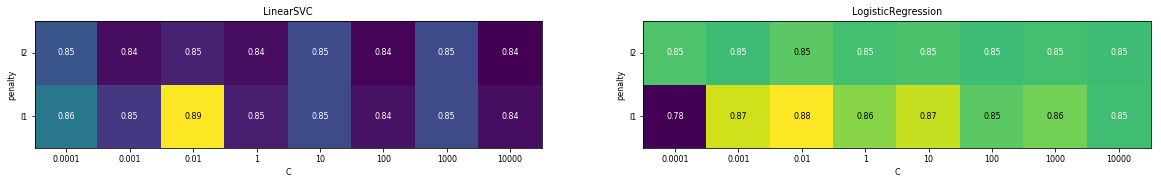

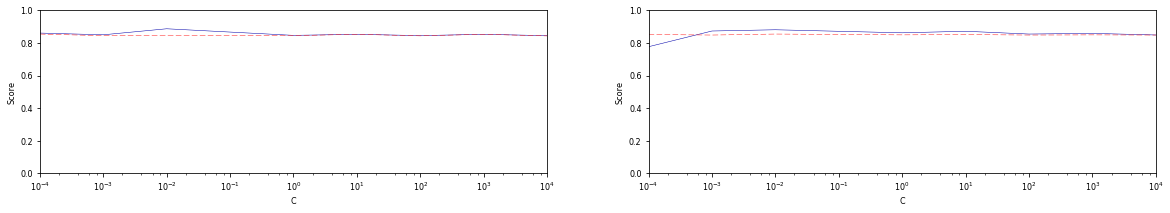

In [15]:
from sklearn.model_selection import KFold

percentage = 0.05       # A multiplier which controls the percentage of data we use, set to 1 to run with all data

# reduce data set size by the given percentage
x_data = X[:int(len(X)*percentage)];
y_data = y[:int(len(y)*percentage)];

# Create data
X_train, X_test, y_train, y_test = train_test_split(
        x_data, y_data, random_state=0)
   
# Run for several parameters
param_grid = { 'C': [0.0001, 0.001, 0.01, 1, 10, 100, 1000, 10000], 'penalty': ["l1", "l2"] }

# k-fold
kf = KFold(n_splits=10, shuffle=True, random_state=0)

# Create two subplots
fig, axes = plt.subplots(1, 2,  figsize=(20, 3))
fig2, axes2 = plt.subplots(1, 2,  figsize=(20, 3))
for (m, ax, ax2) in zip([LinearSVC, LogisticRegression], axes, axes2):
    grid_search = GridSearchCV(m(dual=False), param_grid, cv=kf, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    # Visualize all results
    results = pd.DataFrame(grid_search.cv_results_)
    scores = np.array(results.mean_test_score).reshape(2, 8)
    
    # plot the mean cross-validation scores
    ax.set_title(m.__name__)
    mglearn.tools.heatmap(scores, ax=ax, xlabel='C', xticklabels=param_grid['C'],
                          ylabel='penalty', yticklabels=param_grid['penalty'], cmap="viridis");
    
    ax2.set_ylim(0, 1)
    ax2.set_xlim(0.0001, 10000)
    ax2.set_xscale("log", nonposx='clip')
    ax2.set_xlabel("C")
    ax2.set_ylabel("Score")
    ax2.plot(param_grid['C'], scores[0], label="L1")
    ax2.plot(param_grid['C'], scores[1], label="L2")

We then used the optimal parameter to find if the results improved over the default parameters:

In [18]:
# -- Settings --
percentage = 1       # A multiplier which controls the percentage of data we use, set to 1 to run with all data

# reduce data set size by the given percentage
x_data = X[:int(len(X)*percentage)];
y_data = y[:int(len(y)*percentage)];

# Create data
X_train, X_test, y_train, y_test = train_test_split(
        x_data, y_data, random_state=0)

# Run for default
for m in [LinearSVC]:
    model = m(C=0.01, penalty="l1", dual=False)
    model.fit(X_train, y_train)
    print("Performance for model %s: %s" % (m.__name__, model.score(X_test, y_test)))

Performance for model LinearSVC: 0.907028571429


Even with the best parameters we could find, we found out that kNN results in a better model compared to the linear classification methods.

## Model selection (4 points (2+2))
Study how RandomForest hyperparameters interact on the Ionosphere dataset (OpenML ID 59).

- Optimize a RandomForest, varying both $n\_estimators$ and $max\_features$ at the same time. Use a nested cross-validation and a grid search (or random search) over the possible values, and measure the AUC. Explore how fine-grained this grid/random search can be, given your computational resources. What is the optimal AUC performance you find?
- Again, vary both hyperparameters, but this time use a grid search and visualize the results as a plot (heatmap) $n\_estimators \times max\_features \rightarrow AUC$ with AUC visualized as the color of the data point. Try to make the grid as fine as possible. Interpret the results. Can you explain your observations? What did you learn about tuning RandomForests?

Hint: Running this experiment can take a while, so start early and use a feasible grid/random search. Start with a coarse grid or few random search iterations.
Hint: Use a log scale (1,2,4,8,16,...) for $n\_estimators$. Vary $max\_features$ linearly between 1 and the total number of features. Note that, if you give $max\_features$ a float value, it will use it as [the percentage of the total number of features](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).


1.0

Grid-Search with AUC
Best parameters: {'n_estimators': 128, 'max_features': 3}
Best cross-validation score (AUC): 0.973


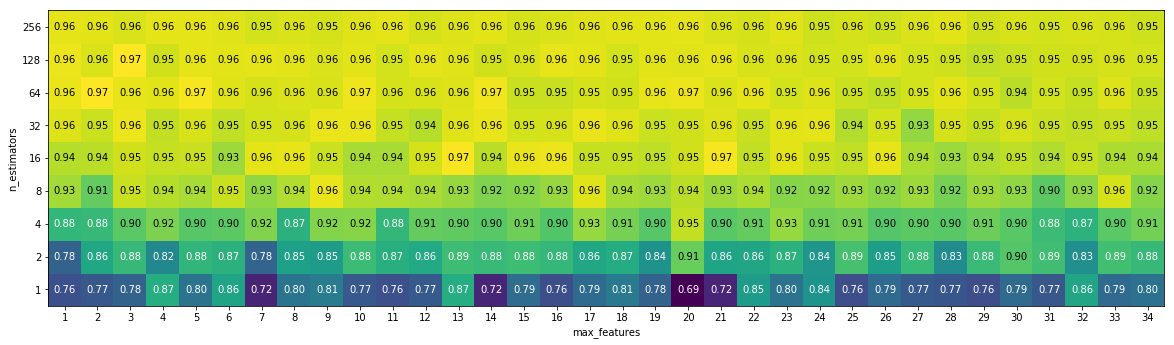

In [521]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

ionosphere = oml.datasets.get_dataset(59) # Download Ionosphere data
X, y = ionosphere.get_data(target=ionosphere.default_target_attribute); # Get the predictors X and the labels y

# -- Settings --
percentage = 1       # A multiplier which controls the percentage of data we use, set to 1 to run with all data

# reduce data set size by the given percentage
x_data = X[:int(len(X)*percentage)];
y_data = y[:int(len(y)*percentage)];

# Run for several parameters
param_grid = { 'max_features': list(range(1,35)), 'n_estimators': [1, 2, 4, 8, 16, 32, 64, 128, 256] }

# Print best prediction for a nested cross validation grid search 
scores = cross_val_score(RandomizedSearchCV(RandomForestClassifier(), param_grid, n_jobs=-1, scoring="roc_auc", cv=5),
                         x_data, y_data, scoring="roc_auc", cv=5)
print(scores.max())

# Create grid search
grid = GridSearchCV(RandomForestClassifier(), param_grid, n_jobs=-1, scoring="roc_auc", cv=5)
grid.fit(x_data, y_data)
print("\nGrid-Search with AUC")
print("Best parameters:", grid.best_params_)
print("Best cross-validation score (AUC): {:.3f}".format(grid.best_score_))

# Visualize all results
results = pd.DataFrame(grid.cv_results_)
scores = np.array(results.mean_test_score).reshape(34, 9)

# Set plot size
plt.figure(figsize=(20,7))

# plot the mean cross-validation scores
mglearn.tools.heatmap(np.transpose(scores), ylabel='n_estimators', yticklabels=param_grid['n_estimators'],
                      xlabel='max_features', xticklabels=param_grid['max_features'], cmap="viridis");


#### Results
We found an AUC of 1.0 as optimal performance when using nested cross-validation on the dataset.

We then used a grid search across a set of estimators and features and plotted the resulting AUCs in a heatmap shown above. We can clearly see there are several high values, but none of them reach 1.0. Most notably, when we increase the number of estimators, the values tend to get better. However, when we increase the maximum amount of features, this benefit declines.

Therefore, we conclude that a low amount of estimators is clearly worse in most cases. About 16/32 seems to be sufficient, any further increase does not improve the results significantly. This was to be expected, since random forests take the best tree it can find, hence increasing the number of estimators will usually increase the AUC.

Similarly, a low amount of max features seems to work very well, but increasing it may reduce computation time.

## Decision tree heuristics (1 point)
Consider the toy training set created below. It predicts whether your date agrees to go out with you depending on the weather.

Learn a decision tree:

- Implement functions to calculate entropy and information gain
- What is the class entropy for the entire dataset? What is the information gain when you split the data using the *Water* feature?
- Implement a basic decision tree:
    - Select a feature to split on according to its information gain. If multiple features are equally good, select the leftmost one.
    - Split the data and repeat until the tree is complete.
    - Print out the results (nodes and splits).
- Now train a scikit-learn decision tree on the same data. Do you get the same result? Explain.

In [5]:
df = pd.DataFrame({"Sky":['sunny','sunny','rainy','sunny','sunny'],
                   "AirTemp":['warm','warm','warm','cold','warm'],
                   "Humidity":['normal','high','high','high','normal'],
                   "Wind":['strong','strong','strong','strong','weak'],
                   "Water":['warm','warm','cool','warm','warm'],
                   "Forecast":['same','same','change','change','same'],
                   "Date?":['yes','yes','no','yes','no']
                   });
df = df[['Sky', 'AirTemp', 'Humidity', 'Wind', 'Water', 'Forecast', 'Date?']] # Fix column ordering
df # print

,Sky,AirTemp,Humidity,Wind,Water,Forecast,Date?
0,sunny,warm,normal,strong,warm,same,yes
1,sunny,warm,high,strong,warm,same,yes
2,rainy,warm,high,strong,cool,change,no
3,sunny,cold,high,strong,warm,change,yes
4,sunny,warm,normal,weak,warm,same,no


In [6]:
# Calculate entropy
def entropy(pos, neg):
    if pos == 0 or neg == 0:
        ent = 0
    else:
        tot = pos+neg 
        posp = pos/tot
        negp = neg/tot
        ent = -(posp*math.log2(posp))-(negp*math.log2(negp))
    return ent

def info_gain(pos1,neg1,pos2,neg2):
    tot = pos1+pos2+neg1+neg2
    ent1 = entropy((pos1+pos2), (neg1+neg2))
    ent2 = entropy(pos1,neg1)
    ent3 = entropy(pos2,neg2)
    inf_gain = ent1 - ((((pos1+neg1)/tot)*ent2)+(((pos2+neg2)/tot)*ent3)) 
    return inf_gain


#Class Entropy
print(entropy(3,2))

def getSplitValue(data,target,split,value):
    left = 0
    right = 0 
    if(split == None):
        for i, row in data.iterrows():
            if (row[target] == "yes"):
                left = left + 1
            else:
                right = right + 1
    else:
        for i, row in data.iterrows():
            if(row[split] == value):
                if(row[target] == "yes"):
                    left = left + 1
                else:
                    right = right + 1

    return  left, right

#Information Gain when splitting on water
split_value_1 = getSplitValue(df, "Date?","Water", "warm")
split_value_2 = getSplitValue(df, "Date?","Water", "cool")
print(info_gain(split_value_1[0],split_value_1[1],split_value_2[0],split_value_2[1]))



#Making Decision Tree
def decisionTree(target, df):
    highest = 0
    high_lab = ""
    for label in df.columns: 
        if (label != target):  
            cValues = df[label].unique()
            if (len(cValues)>=2): 
                split_value_1 = getSplitValue(df, target,label,cValues[0])
                split_value_2 = getSplitValue(df, target,label,cValues[1])
                ig = info_gain(split_value_1[0],split_value_1[1],split_value_2[0],split_value_2[1])
                if highest < ig:
                    highest = ig
                    high_lab = label
                    cv1 = cValues[0]
                    cv2 = cValues[1]
    if (high_lab == ""):
        print("No split")
        return;
    print("We split on %s, which has an information gain of %s" % (high_lab, highest))
    df_left = df.loc[df[high_lab] == cv1]
    df_right = df.loc[df[high_lab] == cv2]
    print("left subtree has size %s, right subtree has size %s" % (len(df_left), len(df_right)))
    
    print("Recurse left")
    decisionTree(target, df_left)
    print("Recurse right")
    decisionTree(target, df_right)

# End function
(decisionTree("Date?", df))


0.9709505944546686
0.3219280948873623
We split on Sky, which has an information gain of 0.3219280948873623
left subtree has size 4, right subtree has size 1
Recurse left
We split on Wind, which has an information gain of 0.8112781244591328
left subtree has size 3, right subtree has size 1
Recurse left
No split
Recurse right
No split
Recurse right
No split


In [9]:
#scikit learn decision tree

from sklearn.tree import DecisionTreeClassifier

df2 = pd.DataFrame({"Sky":[1,1,0,1,1],
                   "AirTemp":[1,1,1,0,1],
                   "Humidity":[1,0,0,0,1],
                   "Wind":[1,1,1,1,0],
                   "Water":[1,1,0,1,1],
                   "Forecast":[1,1,0,0,1],
                   "Date?":[1,1,0,1,0]
                   });
df2 = df2[['Sky', 'AirTemp', 'Humidity', 'Wind', 'Water', 'Forecast', 'Date?']] # Fix column ordering
df2 
l = list(df2.columns[:6])
y = df2["Date?"]
X = df2[l]
tree1 = DecisionTreeClassifier()
tree1.fit(X,y)

# Creates a .dot file
from sklearn.tree import export_graphviz
export_graphviz(tree1, out_file="tree.dot", class_names=["yes", "no"], 
                feature_names=feat, impurity=False, filled=True)
# Open and display
import graphviz
with open("tree.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

## Random Forests (4 points (1+1+2))
Study the effect of the number of trees in a RandomForest on the EEG-eye-state dataset (http://www.openml.org/d/1471). This dataset measures brain activity using 15 sensors, and you need to predict whether the person's eyes are open or closed. 

* Train a RandomForest classifier on this dataset with an increasing number of trees (on a log scale as above). Plot the Out-Of-Bag error against the number of trees.
    - The Out-Of-Bag error is the test error obtained when using bootstrapping, and using the non-drawn data points as the test set. This is what a RandomForest does internally, so you can retrieve it from the classifier. The code below hints on how to do this.
* Construct the same plot, but now use 10-fold Cross-validation and error rate instead of the OOB error. Compare the two. What do you learn from this?
* Compare the performance of the RandomForest ensemble with that of a single full decision tree. Compute the AUC as well as the bias and variance. Does the bias and variance increase/decrease for the ensemble? Does the number of trees affect the result?

Hint: Error rate = 1 - accuracy  
Hint: We discussed bias-variance decomposition in class. It is not included in scikit-learn, so you'll need to implement it yourself.

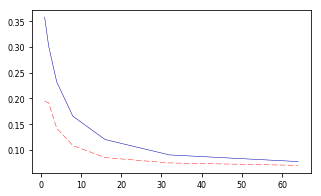

In [234]:
eeg = oml.datasets.get_dataset(1471) # Download Ionosphere data
X, y = eeg.get_data(target=eeg.default_target_attribute);

# Out of bag errors can be retrieved from the RandomForest classifier. You'll need to loop over the number of trees.
# http://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html
from sklearn.ensemble import RandomForestClassifier

# Compute oob-errors
trees = [1, 2, 4, 8, 16, 32, 64]#, 128, 256]
oobError = []
for n_trees in trees:
    clf = RandomForestClassifier(n_estimators=n_trees, n_jobs=-1, oob_score=True)
    clf.fit(X, y)
    oobError.append(1 - clf.oob_score_)

plt.plot(trees, oobError)

# Compute error rates
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

kf = KFold(n_splits=10, shuffle=True, random_state=0)

errorRates = []
for n_trees in trees:
    clf = RandomForestClassifier(n_estimators=n_trees)
    errorRates.append(1 - cross_val_score(clf, X, y, n_jobs=-1, cv=kf).mean())
    
plt.plot(trees, errorRates)

Comparing the error rate and oob error we can see the oob error tends to give higher error values.

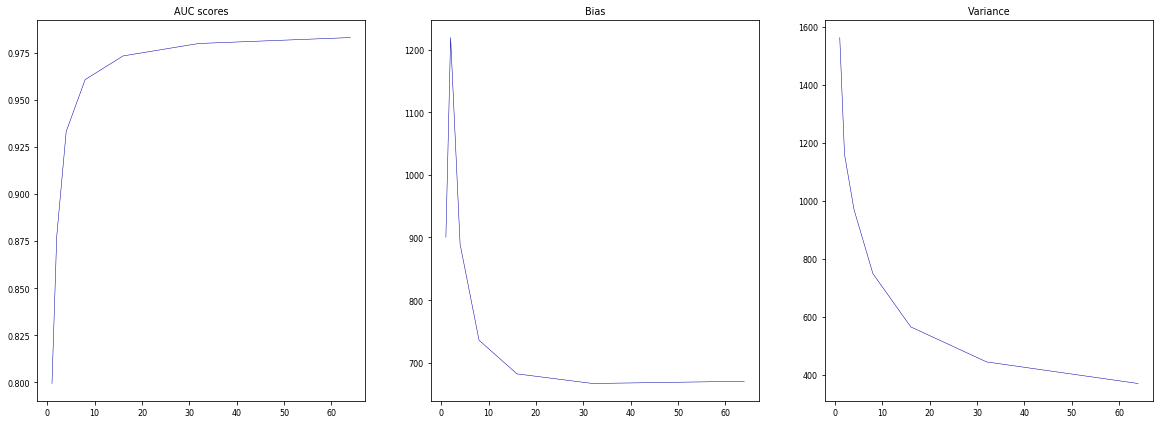

In [56]:
# Compute AUC and bias and variance
from sklearn.metrics import make_scorer
from sklearn.model_selection import ShuffleSplit
from sklearn.ensemble import RandomForestClassifier

n_repeats = 100
bs = ShuffleSplit(test_size=.66, train_size=.34, n_splits=n_repeats, random_state=0)

biasValues = []
varValues = []
aucScores = []
trees = [1, 2, 4, 8, 16, 32, 64]

fig, axes = plt.subplots(1, 3,  figsize=(20, 7))
for n_trees in trees:
    # Compute auc score
    aucScores.append(cross_val_score(RandomForestClassifier(n_estimators=n_trees), X, y, cv=kf, n_jobs=-1, scoring="roc_auc").mean())
    
    # classifier for 
    clf = RandomForestClassifier(n_estimators=n_trees, n_jobs=-1);

    # Store sample predictions
    y_all_pred = [[] for _ in range(len(y))]

    # Train classifier on each bootstrap and score predictions
    for i, (train_index, test_index) in enumerate(bs.split(X)):
        # Train and predict
        clf.fit(X[train_index], y[train_index])
        y_pred = clf.predict(X[test_index])

        # Store predictions
        for i,index in enumerate(test_index):
            y_all_pred[index].append(y_pred[i])

    # Compute bias, variance, error
    bias_sq = sum([ (1 - x.count(y[i])/len(x))**2 * len(x)/n_repeats
                for i,x in enumerate(y_all_pred)])
    var = sum([((1 - ((x.count(0)/len(x))**2 + (x.count(1)/len(x))**2))/2) * len(x)/n_repeats
               for i,x in enumerate(y_all_pred)])
    
    biasValues.append(bias_sq)
    varValues.append(var)
axes[0].set_title("AUC scores")
axes[0].plot(trees, aucScores)
axes[1].set_title("Bias")
axes[1].plot(trees, biasValues)
axes[2].set_title("Variance")
axes[2].plot(trees, varValues)

## A regression benchmark (1 point)
Consider the liver-disorder dataset (http://www.openml.org/d/8). The goal is to predict how much alcohol someone consumed based on blood test values.

- Take a selection of the algorithms that we covered in class that can do regression.
- Based on what you learned in the previous exercises, make educated guesses about good hyperparameter values and set up a grid or random search.
- Evaluate all models with 10-fold cross-validation and root mean squared error (RMSE). Report all results. Which model yields the best results?

113 113
Results of linear regression: 1.51870433438
Results of lasso regression: 1.48560295681
Starting grid search..
Best parameters: {'gamma': 0.01, 'C': 10, 'kernel': 'rbf'}
Best score: 2.015


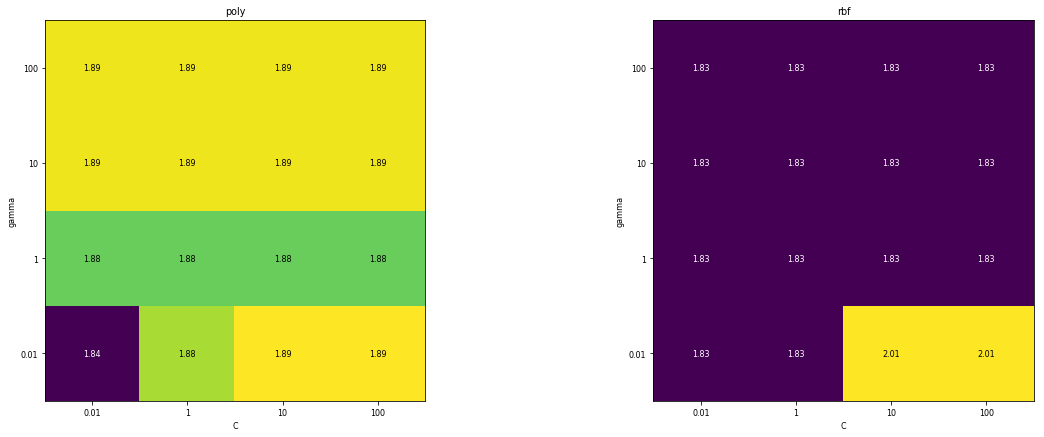

In [38]:
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import linear_model

# Load data
liver = oml.datasets.get_dataset(8) # Download Liver-disorders data
X, y = liver.get_data(target=liver.default_target_attribute);

percentage = 0.33
X = X[:int(len(X)*percentage)];
y = y[:int(len(y)*percentage)];
print(len(X), len(y))

# Create k fold
kf = KFold(n_splits=10, shuffle=True, random_state=0)

# Create RMSE scoring
def rmse(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true, y_pred))

# Linear regression
score = cross_val_score(linear_model.LinearRegression(), X, y, cv=kf, scoring=make_scorer(rmse))
print("Results of linear regression: %s" % score.mean())

# Lasso
score = cross_val_score(linear_model.Lasso(), X, y, cv=kf, scoring=make_scorer(rmse))
print("Results of lasso regression: %s" % score.mean())


# Run for several parameters
param_grid = {
    'kernel':['poly', 'rbf'], 
    'C': [0.01, 1, 10, 100], 
    'gamma': [0.01, 1, 10, 100]
}
# Create three subplots
numPlots=len(param_grid['kernel'])
fig, axes = plt.subplots(1, numPlots,  figsize=(20, 7))
print("Starting grid search..")
grid = GridSearchCV(SVC(), param_grid, n_jobs=-1, scoring=make_scorer(rmse)) #cv=kf, scoring=make_scorer(rmse))
grid.fit(X, y)

print("Best parameters: %s" % (grid.best_params_))
print("Best score: {:.3f}".format(grid.best_score_))

# Visualize all results
results = pd.DataFrame(grid.cv_results_)
scores = np.array(results.mean_test_score).reshape(len(param_grid['C']), 
                                                   len(param_grid['gamma']), 
                                                   len(param_grid['kernel']))


# Visualize the results
for i, ax in zip(range(numPlots), axes):
    # plot the heatmap of kernel scores
    ax.set_title(param_grid['kernel'][i])
    mglearn.tools.heatmap(np.transpose(scores[:,:,i]), ax=ax, ylabel='gamma', yticklabels=param_grid['gamma'],
                          xlabel='C', xticklabels=param_grid['C'], cmap="viridis");